# Meshed AC-DC example

This example has a 3-node AC network coupled via AC-DC converters to a 3-node DC network. There is also a single point-to-point DC using the Link component.

The data files for this example are in the examples folder of the github repository: <https://github.com/PyPSA/PyPSA>.

In [1]:
import pypsa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline
plt.rc("figure", figsize=(8, 8))

In [2]:
network = pypsa.examples.ac_dc_meshed(from_master=True)

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 17, 1].

INFO:pypsa.io:Imported network ac-dc-meshed.nc has buses, carriers, generators, global_constraints, lines, links, loads


In [3]:
# get current type (AC or DC) of the lines from the buses
lines_current_type = network.lines.bus0.map(network.buses.carrier)
lines_current_type

Line
0    AC
1    AC
2    DC
3    DC
4    DC
5    AC
6    AC
Name: bus0, dtype: object

C:\Users\Julian\Programs\anaconda3\envs\ma_env\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Julian\Programs\anaconda3\envs\ma_env\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Julian\Programs\anaconda3\envs\ma_env\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Julian\Programs\anaconda3\envs\ma_env\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', Down

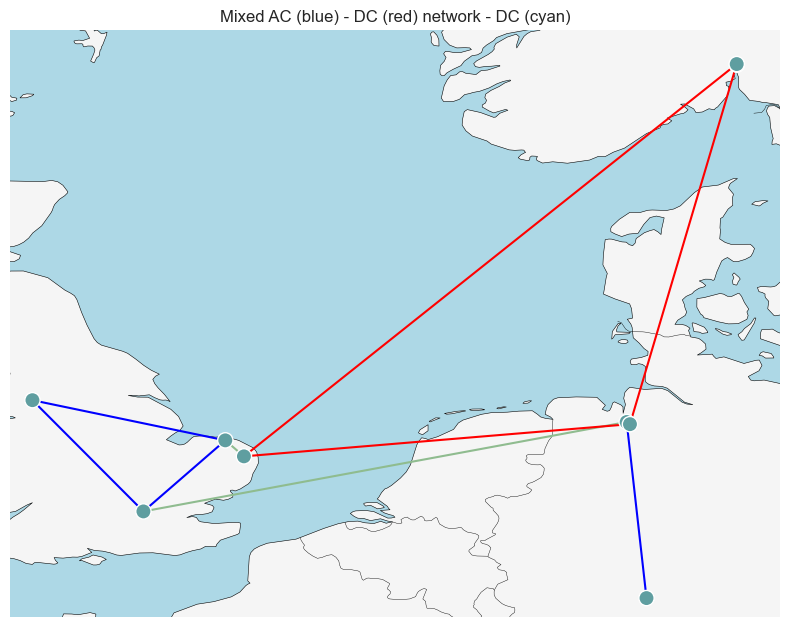

In [4]:
network.plot(
    line_colors=lines_current_type.map(lambda ct: "r" if ct == "DC" else "b"),
    title="Mixed AC (blue) - DC (red) network - DC (cyan)",
    color_geomap=True,
    jitter=0.3,
)
plt.tight_layout()

In [5]:
network.links.loc["Norwich Converter", "p_nom_extendable"] = False

We inspect the topology of the network. Therefore use the function `determine_network_topology` and inspect the subnetworks in `network.sub_networks`.

In [6]:
network.determine_network_topology()
network.sub_networks["n_branches"] = [
    len(sn.branches()) for sn in network.sub_networks.obj
]
network.sub_networks["n_buses"] = [len(sn.buses()) for sn in network.sub_networks.obj]

network.sub_networks

attribute,carrier,slack_bus,obj,n_branches,n_buses
SubNetwork,,,,,
0,AC,Manchester,SubNetwork 0,3,3
1,DC,Norwich DC,SubNetwork 1,3,3
2,AC,Frankfurt,SubNetwork 2,1,2
3,AC,Norway,SubNetwork 3,0,1


The network covers 10 time steps. These are given by the `snapshots` attribute.

In [7]:
network.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)

There are 6 generators in the network, 3 wind and 3 gas. All are attached to buses:

In [8]:
network.generators

,bus,capital_cost,efficiency,marginal_cost,p_nom,p_nom_extendable,p_nom_min,carrier,control,type,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Manchester Wind,Manchester,2793.651603,1.000000,0.110000,80.0,True,100.0,wind,Slack,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Manchester Gas,Manchester,196.615168,0.350026,4.532368,50000.0,True,0.0,gas,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Norway Wind,Norway,2184.374796,1.000000,0.090000,100.0,True,100.0,wind,Slack,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Norway Gas,Norway,158.251250,0.356836,5.892845,20000.0,True,0.0,gas,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Frankfurt Wind,Frankfurt,2129.456122,1.000000,0.100000,110.0,True,100.0,wind,Slack,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Frankfurt Gas,Frankfurt,102.676953,0.351666,4.086322,80000.0,True,0.0,gas,PQ,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


We see that the generators have different capital and marginal costs. All of them have a `p_nom_extendable` set to `True`, meaning that capacities can be extended in the optimization.

The wind generators have a per unit limit for each time step, given by the weather potentials at the site. 

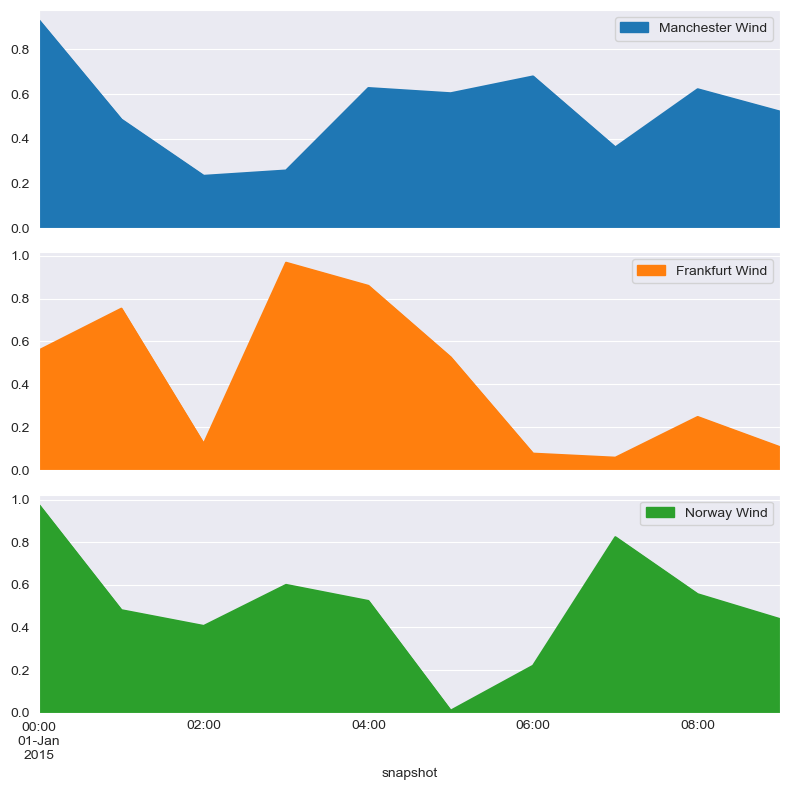

In [9]:
network.generators_t.p_max_pu.plot.area(subplots=True)
plt.tight_layout()

Alright now we know how the network looks like, where the generators and lines are. Now, let's perform a optimization of the operation and capacities.

In [10]:
network.lopf(pyomo=False);

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.0s
INFO:pypsa.linopf:Solve linear problem using Glpk solver


FileNotFoundError: [WinError 2] The system cannot find the file specified

The objective is given by:

In [ ]:
network.objective

Why is this number negative? It considers the starting point of the optimization, thus the existent capacities given by `network.generators.p_nom` are taken into account.  

The real system cost are given by

In [ ]:
network.objective + network.objective_constant

The optimal capacities are given by `p_nom_opt` for generators, links and storages and `s_nom_opt` for lines.

Let's look how the optimal capacities for the generators look like.

In [ ]:
network.generators.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))
plt.tight_layout()

Their production is again given as a time-series in `network.generators_t`.

In [ ]:
network.generators_t.p.div(1e3).plot.area(subplots=True, ylabel="GW")
plt.tight_layout()

What are the Locational Marginal Prices in the network. From the optimization these are given for each bus and snapshot.

In [ ]:
network.buses_t.marginal_price.mean(1).plot.area(figsize=(8, 3), ylabel="Euro per MWh")
plt.tight_layout()

We can inspect futher quantities as the active power of AC-DC converters and HVDC link.

In [ ]:
network.links_t.p0

In [ ]:
network.lines_t.p0

...or the active power injection per bus.

In [ ]:
network.buses_t.p